In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [205]:
sns.set(style="whitegrid")
df = pd.read_csv("options_KR.csv", parse_dates=["Date"], index_col="Date")
df.head()

,VKOSPI,KOSPI200,Open_interest,For_KOSPI_Netbuying_Amount,For_Future_Netbuying_Quantity,For_Call_Netbuying_Quantity,For_Put_Netbuying_Quantity,Indiv_Future_Netbuying_Quantity,Indiv_Call_Netbuying_Quantity,Indiv_Put_Netbuying_Quantity,PCRatio,Day_till_expiration,Day_of_a_week
Date,,,,,,,,,,,,,
2009-06-02,33.45,180.90,4377777,4.940000e+11,-4953,-24646,6581,1228,-466,31336,0.94,7,Tue
2009-06-03,32.66,180.47,4562690,-8.997074e+10,47,-57128,46851,399,127709,-22259,0.93,6,Wed
2009-06-04,32.56,180.31,4827524,-1.090000e+11,-7666,-2000,48883,5744,262558,10367,0.87,5,Thu
2009-06-05,32.95,175.75,5022921,9.842024e+10,969,64792,27196,-1688,79789,113935,0.89,4,Fri
2009-06-08,30.41,177.77,5293996,4.329179e+10,5797,10995,23123,-5534,97154,146244,0.81,3,Mon


# Nettoyage et Preparation des Donnees


In [206]:
# Nettoyer les données selon les exploitations dans main.ipynb
df_nettoye = df.copy()

df_nettoye["For_KOSPI_Netbuying_Amount"] = df_nettoye[
    "For_KOSPI_Netbuying_Amount"
].apply(lambda x: int(float(x)))
# Supprimer les valeurs aberrantes
df_nettoye = df_nettoye.loc[df_nettoye["Indiv_Call_Netbuying_Quantity"] < 600000]

# Supprimer les colonnes inutiles
df_nettoye = df_nettoye.drop(columns=["Day_of_a_week", "Day_till_expiration"])

df_nettoye.head()

X = df_nettoye.drop(columns=["VKOSPI"])
y = df_nettoye["VKOSPI"]

In [207]:
def split_time_dataset(X, y, train_ratio):
    assert X.shape[0] == len(y)

    n = X.shape[0]
    index = round(n * train_ratio)

    X_train, X_test = X.iloc[:index,], X.iloc[index:,]
    y_train, y_test = y[:index], y[index:]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_time_dataset(X, y, train_ratio=0.8)

RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

# Régression linéaire simple


In [208]:
def train_predict_LinearRegression(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rsme = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Performance du modèle LinearRegression")
    print(f"RMSE: {rsme:.2f}")


train_predict_LinearRegression(X_train, y_train, X_test, y_test)

Performance du modèle LinearRegression
RMSE: 3.04


# Régression Ridge Et LASSO


Lasso Régression - Meilleur alpha selon RMSE: 22.56453846153846
Lasso Régression - Minimum RMSE: 2.335139479110658


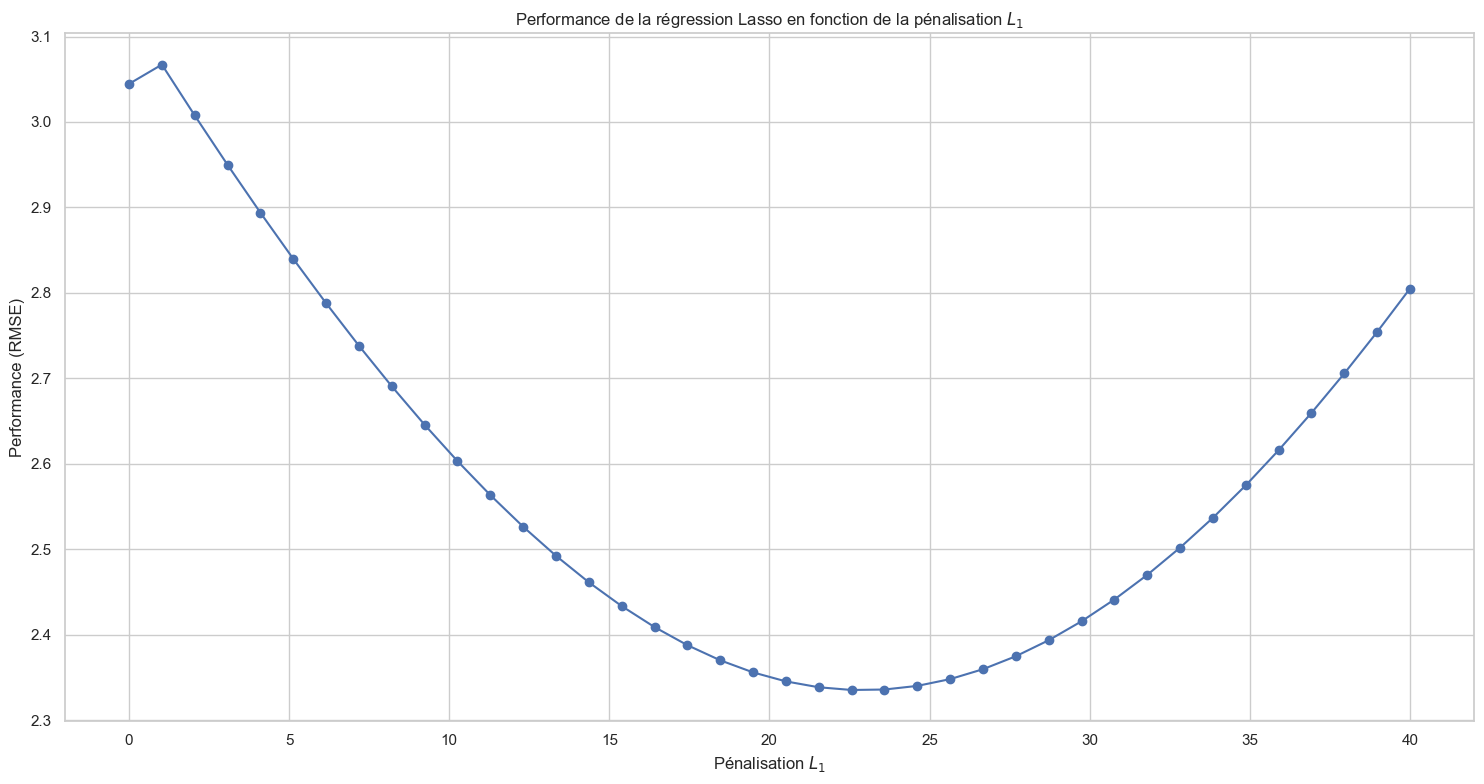

Ridge Régression - Meilleur alpha selon RMSE: 8.205923076923076
Ridge Régression - Minimum RMSE: 3.0431146592726845


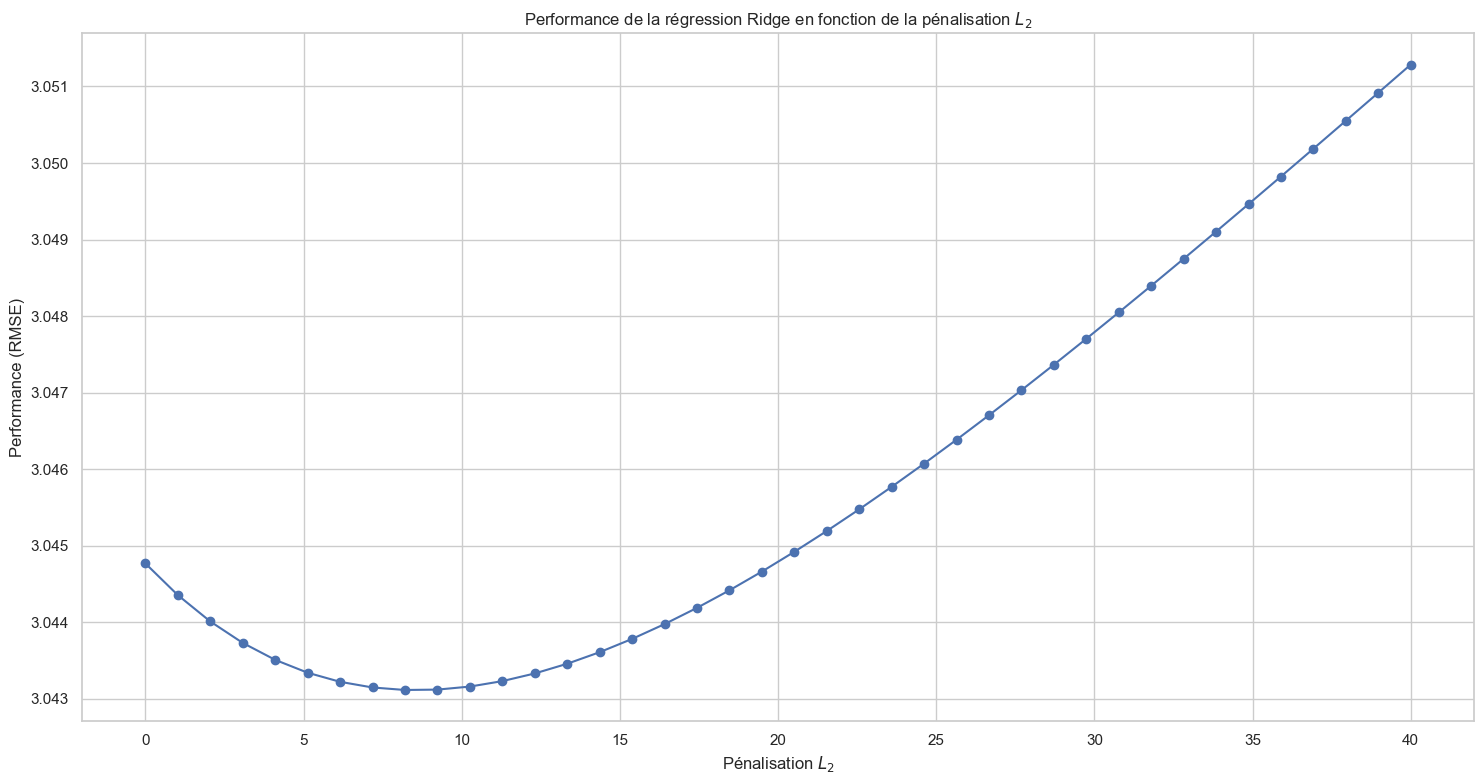

In [209]:
def find_best_alpha(model_type, X_train, y_train, X_test, y_test, alpha_grid):
    warnings.filterwarnings("ignore")
    if model_type not in ["lasso", "ridge"]:
        raise ValueError("model_type doit être 'lasso' ou 'ridge'")

    rmse_result = []

    for alpha in alpha_grid:
        if model_type == "lasso":
            model = Lasso(alpha=alpha)
            penalty_type = "$L_1$"
        elif model_type == "ridge":
            model = Ridge(alpha=alpha)
            penalty_type = "$L_2$"

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_result.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        # r2_result.append(r2_score(y_test, y_pred))

    min_index_RMSE = np.argmin(rmse_result)
    best_alpha_RMSE = alpha_grid[min_index_RMSE]

    print(
        f"{model_type.capitalize()} Régression - Meilleur alpha selon RMSE: {best_alpha_RMSE}"
    )
    print(
        f"{model_type.capitalize()} Régression - Minimum RMSE: {rmse_result[min_index_RMSE]}"
    )

    plt.figure(figsize=(15, 8))

    plt.subplot(1, 1, 1)
    plt.plot(alpha_grid, rmse_result, "o-")
    plt.xlabel(f"Pénalisation {penalty_type}")
    plt.ylabel("Performance (RMSE)")
    plt.title(
        f"Performance de la régression {model_type.capitalize()} en fonction de la pénalisation {penalty_type}"
    )

    plt.tight_layout()
    plt.show()

    return best_alpha_RMSE


alpha_grid = np.linspace(0.001, 40, 40)

best_alpha_lasso = find_best_alpha(
    "lasso", X_train, y_train, X_test, y_test, alpha_grid
)

best_alpha_ridge = find_best_alpha(
    "ridge", X_train, y_train, X_test, y_test, alpha_grid
)

# Régression ElasticNet et recherche par grille


Grâce au code précédent, nous avons trouvé les meilleures valeurs de alpha pour Lasso et Ridge. Nous pouvons utiliser ces résultats pour guider le réglage des paramètres d'ElasticNet, en commençant la recherche autour de la Moyen des valeurs de alpha pour Lasso et Ridge. Comme le RMSE optimal de Lasso est inférieur à celui de Ridge, nous allons fixer la valeur de l1_ratio à un niveau superieur à 0,5, afin de donner une plus grande importance à Lasso dans le modèle ElasticNet.


ElasticNet - Meilleur alpha: 25.798461694284303
ElasticNet - Meilleur l1_ratio: 0.8888888888888888
ElasticNet - Minimum RMSE: 2.3350360120134


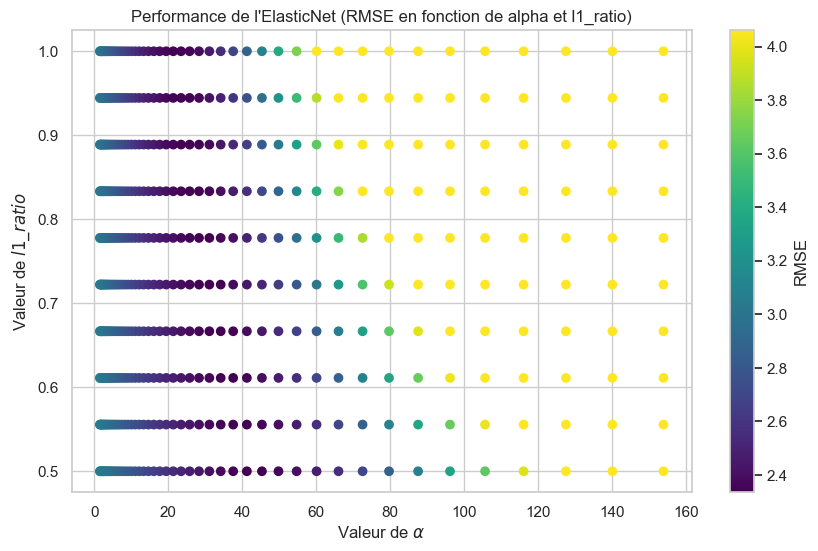

In [210]:
def optimize_elasticnet(X_train, y_train, X_test, y_test, lasso_alpha, ridge_alpha):
    # uliser la moyenne des alphas de Lasso et Ridge comme alpha initial d'ElasticNet
    initial_alpha = (lasso_alpha + ridge_alpha) / 2
    if initial_alpha <= 0:
        raise ValueError("Initial alpha must be greater than 0.")
    log_initial_alpha = max(np.log10(initial_alpha), -3)
    alpha_grid = np.logspace(log_initial_alpha - 1, log_initial_alpha + 1, 50)

    l1_ratios = np.linspace(0.5, 1.0, 10)
    rmse_results = []
    best_rmse = float("inf")
    best_alpha = None
    best_l1_ratio = None

    for l1_ratio in l1_ratios:
        for alpha in alpha_grid:
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            rmse_results.append((alpha, l1_ratio, rmse))
            if rmse < best_rmse:
                best_rmse = rmse
                best_alpha = alpha
                best_l1_ratio = l1_ratio

    print(f"ElasticNet - Meilleur alpha: {best_alpha}")
    print(f"ElasticNet - Meilleur l1_ratio: {best_l1_ratio}")
    print(f"ElasticNet - Minimum RMSE: {best_rmse}")

    alphas = [result[0] for result in rmse_results]
    l1_ratios = [result[1] for result in rmse_results]
    rmses = [result[2] for result in rmse_results]

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(alphas, l1_ratios, c=rmses, cmap="viridis")
    plt.colorbar(scatter, label="RMSE")
    plt.xlabel(r"Valeur de $\alpha$")
    plt.ylabel(r"Valeur de $l1\_ratio$")
    plt.title("Performance de l'ElasticNet (RMSE en fonction de alpha et l1_ratio)")
    plt.show()

    return best_alpha, best_l1_ratio


# alpha_grid = np.logspace(-4, 1, 50)
best_elasticnet_alpha, best_elasticnet_l1_ratio = optimize_elasticnet(
    X_train, y_train, X_test, y_test, best_alpha_lasso, best_alpha_ridge
)

Le fait que l1_ratio = 0.89 signifie que les données favorisent principalement une régularisation en L1, et que les RMSE de LASSO et d'Elasticnet ne sont pas très différentes. Ainsi, on a pas besoin de Elasticnet, et le modèle LASSO est suffisant pour gérer notre problème.


## Meilleurs paramètres

- Simple RMSE : RMSE = 3.04
- Lasso : alpha = 22.56 RMSE = 2.34
- Ridge : alpha = 8.21 RMSE = 3.04
- ElasticNet : alpha = 25.80, Li_ratio = 0.89,RMSE = 2.34


# Régressions polynomiales

Selon les informations ci-dessus, nous avons remarqué que le LASSO est celui qui présente les meilleures performances parmi les trois régressions(Simple/Lasso/Ridge). Nous allons donc combiner le LASSO avec les régressions polynomiales pour vérifier si cela permet d'obtenir une valeur RMSE encore plus basse.


In [211]:
from sklearn.preprocessing import PolynomialFeatures


def polynomial_regularized_regression(
    X_train, y_train, X_test, y_test, best_alpha, max_degree
):


    results = []


    for degree in range(1, max_degree + 1):


        poly = PolynomialFeatures(degree=degree)


        X_train_poly = poly.fit_transform(X_train)


        X_test_poly = poly.transform(X_test)


        model = Lasso(alpha=best_alpha)


        model.fit(X_train_poly, y_train)


        y_pred = model.predict(X_test_poly)


        rmse = np.sqrt(mean_squared_error(y_test, y_pred))


        results.append((degree, rmse))


        print(f"Regression - Degree: {degree}, RMSE: {rmse:.4f}")


    degrees, rmses = zip(*results)


    plt.figure(figsize=(8, 6))


    plt.plot(degrees, rmses, marker="o", label=f"RMSE (Lasso, alpha={best_alpha})")


    plt.title(f"Lasso Regression: RMSE vs Polynomial Degree")


    plt.xlabel("Polynomial Degree")


    plt.ylabel("RMSE")
    plt.legend()
    plt.grid()


    plt.show()

Regression - Degree: 1, RMSE: 2.3351
Regression - Degree: 2, RMSE: 3.8350
Regression - Degree: 3, RMSE: 5.3544


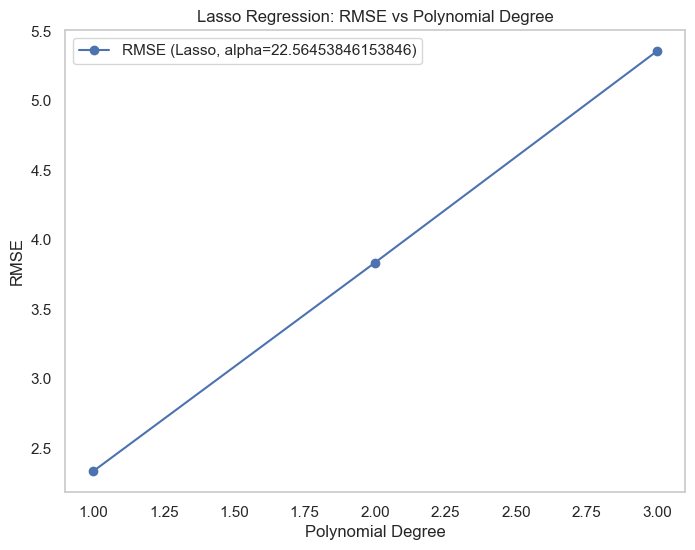

In [212]:
max_degree = 3
polynomial_regularized_regression(
    X_train, y_train, X_test, y_test, best_alpha=best_alpha_lasso, max_degree=max_degree
)

À mesure que le degré du polynôme augmente, l’erreur quadratique moyenne (RMSE) du modèle croît de manière significative. Cela suggère que l’augmentation de la complexité du modèle n’améliore pas ses performances prédictives. Par conséquent, nous retenons le modèle de régression Lasso simple avec un polynôme de degré 1, qui offre les meilleures performances.


# Conclusion

Les performances d'ElasticNet sont proches de celles de LASSO, ce qui montre qu'il tend entièrement vers le comportement du modèle LASSO. De plus, le RMSE de LASSO (2.34) est nettement meilleur que celui de Ridge (RMSE = 3.04) et du modèle simple (RMSE = 3.04). Par ailleurs, le RMSE de Ridge (3,04) est très proche de celui du modèle non régularisé (RMSE = 3,04). En outre, l’augmentation du degré de ce modèle n’améliore pas ses performances prédictives.

Sur ce dataset, LASSO est le modèle le plus adapté parmi les quatre modèles testés. Il peut être utilisé directement comme modèle régression linéaire final. Sinon, nous pouvons explorer d'autres modèles non linéaires pour améliorer les performances.
